<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Анализ-обученной-модели" data-toc-modified-id="Анализ-обученной-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ обученной модели</a></span></li><li><span><a href="#Чек-лист" data-toc-modified-id="Чек-лист-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист</a></span></li></ul></div>

# Определение возраста покупателей

**Описание проекта**

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;  
- Контролировать добросовестность кассиров при продаже алкоголя.  

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.

## Исследовательский анализ данных

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


Нам предоставлено 7591 изображение, которые мы загрузили в размере 224х224 для дальнейшей обработки моделью.

In [3]:
features, target = next(gen_flow)

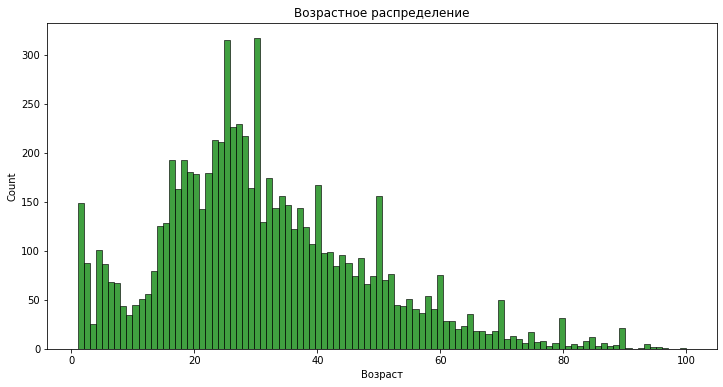

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

In [4]:
plt.figure(figsize=(12, 6))
sns.histplot(data = labels, x = labels['real_age'], bins = 100, color = 'green')
plt.title('Возрастное распределение')
plt.xlabel('Возраст')
plt.show()
labels.real_age.describe()

На графике виден аномальный пик в значениях от 1-10 лет. Также пики приходятся на значения 25, 30, 40 (и так каждые 10 лет)

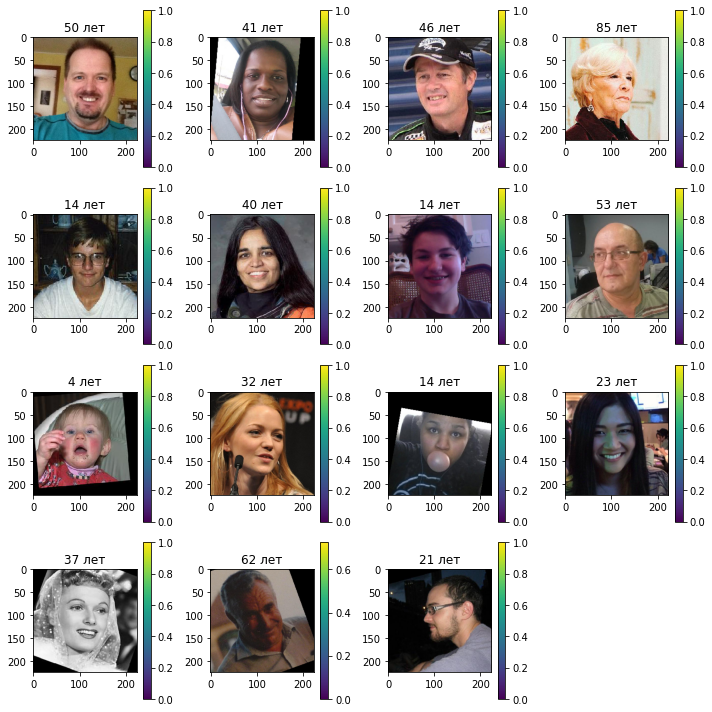

In [5]:
# ознакомтмся с предоставленными изображениями
fig = plt.figure(figsize=(10,10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(f'{target[i]} лет')
    plt.colorbar()
#     plt.xticks([])
#     plt.yticks([])
    plt.tight_layout()

У части изображений наблюдается небольшой разворот и смещение по ширине и высоте, но это не приводит к кардинальному искажению, также присутствуют ч/б фотографии

## Обучение модели

**Задача**

Построить и обучить свёрточную нейронную сеть на датасете с фотографиями людей. Добиться значения MAE на тестовой выборке не больше 8.


```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1/255,
                                       validation_split=0.25,
                                       horizontal_flip=True,
                                       height_shift_range=0.2)
    train = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='training',
        class_mode='raw',
        seed=12345)
    
    return train

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1/255,
                                      validation_split=0.25)
    test = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + '/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        subset='validation',
        class_mode='raw',
        seed=12345)
    
    return test

def create_model(input_shape):
    optimizer = Adam(lr = 0.0001)
    backbone = ResNet50(input_shape=(224, 224, 3),
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAvgPool2D())
    model.add(Dense(1, activation = 'relu'))
    model.compile(loss='mean_squared_error', metrics=['mae'], optimizer=optimizer)
    
    return model

def train_model(model, train_data, test_data, 
                batch_size = 32, epochs = 15, 
                steps_per_epoch = None, validation_steps = None):
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(train_data,
              validation_data = test_data,
              epochs = epochs,
              steps_per_epoch = steps_per_epoch,
              validation_steps = validation_steps,
              verbose=2, shuffle=True)
    
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/15
2022-07-19 10:57:11.962689: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-07-19 10:57:12.360278: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 95s - loss: 322.9662 - mae: 12.7744 - val_loss: 996.9115 - val_mae: 26.8652
Epoch 2/15
178/178 - 87s - loss: 94.9368 - mae: 7.3243 - val_loss: 844.4733 - val_mae: 24.0644
Epoch 3/15
178/178 - 87s - loss: 68.2384 - mae: 6.2631 - val_loss: 337.3978 - val_mae: 13.6223
Epoch 4/15
178/178 - 88s - loss: 51.8427 - mae: 5.5073 - val_loss: 107.2382 - val_mae: 7.7914
Epoch 5/15
178/178 - 87s - loss: 42.5488 - mae: 4.9863 - val_loss: 83.6101 - val_mae: 6.9542
Epoch 6/15
178/178 - 87s - loss: 36.0419 - mae: 4.5953 - val_loss: 87.4833 - val_mae: 6.8421
Epoch 7/15
178/178 - 87s - loss: 29.0325 - mae: 4.1386 - val_loss: 81.3289 - val_mae: 6.9629
Epoch 8/15
178/178 - 87s - loss: 25.7244 - mae: 3.8905 - val_loss: 68.2527 - val_mae: 6.1607
Epoch 9/15
178/178 - 87s - loss: 22.3504 - mae: 3.6558 - val_loss: 100.6400 - val_mae: 7.8264
Epoch 10/15
178/178 - 86s - loss: 19.1306 - mae: 3.3539 - val_loss: 71.6878 - val_mae: 6.4788
Epoch 11/15
178/178 - 86s - loss: 18.1575 - mae: 3.2732 - val_loss: 65.0826 - val_mae: 6.0241
Epoch 12/15
178/178 - 87s - loss: 16.3273 - mae: 3.0735 - val_loss: 71.1695 - val_mae: 6.4908
Epoch 13/15
178/178 - 87s - loss: 13.1552 - mae: 2.7806 - val_loss: 62.3830 - val_mae: 5.8023
Epoch 14/15
178/178 - 88s - loss: 12.3692 - mae: 2.6880 - val_loss: 64.8966 - val_mae: 6.2192
Epoch 15/15
178/178 - 87s - loss: 11.2998 - mae: 2.5666 - val_loss: 60.2646 - val_mae: 5.8769
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 60.2646 - mae: 5.8769
Test MAE: 5.8769

```

## Анализ обученной модели

Для выполнения задачи была использована нейросеть ResNet50, в которую были загружены фото размером 224х224 и количеством изображений в батче 32 шт. Количество эпох было задано 15 с шагом, равным размеру обучающей и валидационной выборкам.В качестве функции потель была задана MSE, а в качестве отслеживания процесса на каждой эпохе - MAE. Adam использовался как алгоритм обучения.  
В результате MAE = 5.88
Т. е погрешность в определении возраста, если округлить, 6 лет. Данный результат подходит для осуществления первой задачи, но для второй слишком большой разброс.